# Tool use pattern

Modern AI systems often need to do things beyond pure text generation: fetch facts, compute values, convert units, or call business APIs - they must interact with external tools to access up-to-date information or perform computations. This ability to call tools is the tool use pattern.

The tool use pattern is a foundational approach in agentic system design where an LLM can invoke external tools—APIs, functions or services — to augment its reasoning and actions. These tools allow the model to fetch up-to-date facts, perform calculations, retrieve structured data, call business logic, or interact with the outside world.

Instead of relying solely on its internal knowledge, the LLM becomes a coordinator: it interprets user intent, decides what tools it needs, and incorporates tool outputs into its final response.

In this notebook, we will implement a single-pass tool-use workflow:
1. The model receives a user request.
2. If the model decides it needs tools, it calls a tool once.
3. We execute the tool, capture their outputs, and hand them back to the model.
4. The model finalizes the answer using those results.

Unlike more advanced patterns (e.g., multi-turn reasoning/acting loops), here we keep it to one tool-use phase then finalization—simple, reliable, and easy to productionize.

In [1]:
import os
from typing import TypedDict, Sequence, Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
import wikipedia
import math
import json

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure OpenAI API key for AI model access
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

### Initialize the language model
The language model serves as the core intelligence of our conversational agent. Here we will configure the AI model with specific parameters that balance response quality, cost and performance.

In [2]:
# Initialize the OpenAI language model
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0.7)

This configuration creates our AI model instance using OpenAI's GPT model.

### Define the agent state
To build a working tool-use system, we need to keep track of what has happened during the interaction: what the user asked, what the model said or requested, and what the tools returned. We do this by defining a simple state object that holds the conversation history. This lets us pass all the relevant context between steps in the workflow.

In LangGraph, this is done using a custom state dictionary. Each node in the graph returns new messages (model output or tool result), and the framework automatically appends these to the evolving state under the hood.

To define this state, we use Python's `TypedDict` and LangGraph’s message reducer utility `add_messages`. The key idea is to keep a list of `BaseMessage` objects representing the evolving conversation, which will be passed from one node to the next as the loop executes.

In [3]:
# Define a dictionary structure for the agent's evolving state
class AgentState(TypedDict):
    """State of the agent for one turn or conversation."""
    # The `messages` field stores the entire chat history (LLM thoughts, tool responses, user input, etc.)
    messages: Annotated[Sequence[BaseMessage], add_messages]

This defines the `AgentState` class, a dictionary used to represent the current state of the agent at any point in the workflow.
* The `messages` field tracks all messages in the interaction. Each message is a `BaseMessage` objects from LangChain. These can include:
  * `HumanMessage` (user input)
  * `AIMessage` (LLM output)
  * `ToolMessage` (tool result)
  * `SystemMessage` (system prompt or internal instruction)
* The `Annotated[..., add_messages]` part instructs LangGraph how to merge or update the `messages` field when nodes return additional messages. Specifically, `add_messages` means new messages are appended to the existing list instead of replacing it.

This pattern gives us a clean and structured way to maintain a full memory of each interaction cycle inside the ReAct loop.

### Define tools
In the tool use pattern, the most important step is to make external capabilities accessible to the LLM. Tools extend the model’s functionality beyond language - allowing it to fetch data, perform calculations, or interact with external systems. In this pattern, the model only has one chance to call tools before producing a final answer, so we define all tools it might need up front.


#### Wikipedia search tool
This tool uses the `wikipedia` Python package to fetch a short summary based on a query.

In [4]:
@tool
def wiki_search(query: str) -> str:
    """Search Wikipedia for the query and return a brief summary of the top result."""
    try:
        # Fetches summary from Wikipedia for the given query (limited to 5 sentences)
        summary = wikipedia.summary(query, sentences=5)
        return summary
    except Exception as e:
        # Return error if the query fails (e.g., disambiguation, page not found)
        return f"Error: {e}"

This function is decorated with `@tool`, making it callable from an LLM within a LangGraph flow. If the model decides it needs to "look something up," it can trigger this tool. The function’s docstring becomes the tool’s description exposed to the LLM. This is how the model knows what each tool does and how to use it properly.

#### Calculator tool
Next, we provide a tool for computing mathematical expressions. This is especially useful when the model wants to offload calculation to a deterministic backend.

In [5]:
@tool
def calculator(expression: str) -> str:
    """Safely evaluate a basic mathematical expression (e.g., '2 + 2 * 5')."""
    try:
        # Use eval in a restricted environment — no access to Python built-ins
        result = eval(expression, {"__builtins__": {}}, {"math": math})
        return str(result)
    except Exception as e:
        # Return error message if evaluation fails
        return f"Error: {e}"

This tool is also marked with `@tool` and leverages `eval()` securely. We explicitly disable Python built-ins to prevent dangerous evaluations, allowing only access to the `math` module.

These are intentionally minimal tools to illustrate the flow. In production we could add HTTP fetchers, databases, environment controls, or proprietary APIs.

#### Expose tools to the model
The agent's LLM needs to "know" about tools (names and signatures). Many LLM wrappers allow binding tools so that the model can emit structured tool-call messages that the runtime interprets. After defining our tools, we expose them to the model in two steps:
- First, create a mapping of tool names to actual tool functions. This will be used later to execute tool calls emitted by the model.
- Then, use `llm.bind_tools()` to let the LLM know which tools are available. This enables it to request tools by name and argument structure in its output.

In [6]:
# Collect tools into a list
tools = [wiki_search, calculator]
# Build a name → tool dictionary for runtime use
tools_by_name = {tool.name: tool for tool in tools}

# Bind tools to the LLM (so it knows what it can call)
llm = llm.bind_tools(tools)

- The `tools_by_name` dictionary is key when interpreting tool calls during graph execution.
- `bind_tools()` effectively informs the LLM: "You can call these tools during your reasoning — here is what they are, what they do, and what arguments they need."

With these pieces in place, the agent is now capable of reasoning about a user query, deciding when it needs help, and using external tools to get it. This is the operational core of the tool use pattern.

### Crate nodes
In this part, we’re setting up the key components (nodes) that define how the agent behaves in the tool-use workflow. This is where the agent thinks what to do, acts by calling tools, and then wraps things up with a final, user-friendly answer.

#### Planning node
The planning step is where the LLM decides what to do next. The LLM receives the entire conversation history plus a system prompt that clearly states the agent’s role and the tools it has at its disposal. The goal here is for the LLM to either answer the user’s query directly or to decide that a tool (or multiple tools) need to be called to fetch information or perform calculations. This step represents the agent’s core reasoning phase, where it plans how to respond intelligently based on available resources.

In [7]:
def call_model(state: AgentState):
    """Planner node: LLM decides if tools are needed or if it can answer directly."""

    # System prompt helps the agent knows its role and available tools
    system_prompt = SystemMessage(
        content="You are a helpful AI assistant. You can use wiki_search or calculator tools if needed."
    )

    # Pass system + history messages (user, assistant, tool) to LLM
    response = llm.invoke([system_prompt] + list(state["messages"]))

    # Append the model's response to the state messages
    return {"messages": [response]}

- A `SystemMessage` sets the behavior and tool awareness of the agent.
- The model is called with a list of prior messages including that system message and all user/model/tool messages so far.
- The return value is a dictionary with a single new assistant message, which will be appended to the state by the graph runtime.

This is the core thinking step of the agent.

#### Tool execution node
Once the planner has decided which tools are needed and has issued tool calls, this node is responsible for actually executing those tools. The agent can handle multiple tool requests at once, running each and collecting their results. This execution step bridges the gap between abstract reasoning (what to do) and concrete action (actually doing it). It ensures tool outputs are returned in a consistent format, ready to be incorporated into the agent’s ongoing dialogue.

In [8]:
def tool_node(state: AgentState):
    """Tool execution node: executes all tools requested by the planner."""

    outputs = []  # Store results of tool calls
    last_message = state["messages"][-1]  # The most recent model message

    # Check for tool calls and iterate through each
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]  # Name of the tool requested
            tool_args = tool_call["args"]  # Arguments passed to the tool

            # Run the tool if found
            if tool_name in tools_by_name:
                result = tools_by_name[tool_name].invoke(tool_args)
            else:
                result = f"Tool '{tool_name}' not found."

            # Package result as ToolMessage
            outputs.append(
                ToolMessage(
                    content=json.dumps(result),  # Serialize output to JSON string
                    name=tool_name,  # Name for identification in history
                    tool_call_id=tool_call.get("id")  # Map output to specific tool call
                )
            )

    # Return the list of tool responses to be appended to message history
    return {"messages": outputs}

- The function inspects the most recent message from the LLM. If it includes tool calls (structured requests emitted by the model), we parse and execute them.
- We look up the correct tool function using its name via `tools_by_name`.
- The results are wrapped in `ToolMessage` objects, including the tool name and optional ID - this makes it easy for the LLM to resolve tool outputs to the original requests.
- These results are returned as new messages, added to the conversation timeline for the next reasoning step.

This is the execution engine of the agent - it performs real-world operations on the model’s behalf.

### Finalization node
Once all tools have been executed, the finalizer prompts the LLM to synthesize a final, user-friendly answer. This is where everything comes together: the original user input, the model's reasoning, and the tool results.

In [9]:
def summarize_node(state: AgentState):
    """Finalizer node: LLM produces the final answer using tool outputs."""

    # Prompt the model to produce a summary based on tool results
    system_prompt = SystemMessage(
        content="You are a helpful assistant. Summarize results from the tools into a final user-friendly answer."
    )

    # Invoke model with full message history, including tool outputs
    response = llm.invoke([system_prompt] + list(state["messages"]))

    # Return the assistant's final message
    return {"messages": [response]}

This step transforms raw data from tool calls into natural, helpful output.
- Like the planner, this node receives the full conversation history (including `ToolMessages`), giving the LLM full context.
- The return is a single assistant message containing the agent's final response to the user - this concludes the workflow.


### Define loop continuation logic
Before we define how the flow of control moves through the graph, we need a mechanism to determine what should happen after the planner runs. Depending on what the LLM decides, we either go directly to the final response, or we need to run external tools first. That decision depends on whether the model made any tool calls.

We now add conditional edges from the planner, to decide whether the agent should keep going (e.g., because a tool was requested) or stop (because the agent has given a final answer).

In [10]:
def needs_tools(state: AgentState) -> str:
    """Check if the planner requested tools or not."""
    # Get the most recent message from the assistant
    last_message = state["messages"][-1]

    # If there are tool calls, continue to tool executor
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        # No tool calls -> go directly to finalizer
        return "direct"

- This function inspects the last message in the agent's message history - which is the planner’s output.
- It checks if that message includes any tool_calls, which are structured indicators that the LLM wants to invoke a tool.
  - If tool calls exist, the function returns "tools", instructing the graph to move to the tool execution node.
  - If not, it returns "direct", skipping the tool phase and routing to the summarization node instead.

This function is used as a conditional edge in the graph to decide the next step after the planning node runs.

### Build the agent graph
Now we wire the workflow together. This is where we assemble the graph that defines the agent’s logic. We are using LangGraph to construct this as a stateful, directed computation graph. Each node represents a phase in the agent’s reasoning process, and edges define how data (i.e., the agent’s state) flows between those nodes.

The control flow will always start with planning. From there, it will branch conditionally: if the model has called tools, we route to the tool executor; if not, we go directly to finalization. After tool use, we also finalize the response. The graph ends there — one tool-use round, then done.

In [11]:
# Build the ReAct workflow graph
graph = StateGraph(AgentState)

# Register the nodes (steps)
graph.add_node("planner", call_model)  # Planning step
graph.add_node("tool_executor", tool_node)  # Tool execution
graph.add_node("finalizer", summarize_node)  # Summarization

# Define edges
graph.add_edge(START, "planner")  # Set the entry point of the graph — where execution begins
graph.add_conditional_edges(  # Add conditional routing from the planner node
    "planner",  # After the planner runs
    needs_tools,  # Run this function to decide where to go next
    {
        "tools": "tool_executor",  # If tools were requested, go to tool executor
        "direct": END,  # If not, skip to the end
    },
)

graph.add_edge("tool_executor", "finalizer")  # After tools are run, always proceed to finalizer
graph.add_edge("finalizer", END)  # Once final answer is generated, we're done

# Compile the graph
agent = graph.compile()

- `StateGraph(AgentState)` creates a new LangGraph state machine that tracks the full conversation state throughout the workflow.
- Each `add_node(...)` call registers a function that handles a specific part of the agent’s logic.
- `add_edge(START, "planner")` defines the graph’s entry point — the planner node always runs first.
- `add_conditional_edges(...)` attaches conditional logic that routes execution to different nodes depending on whether tool calls were made. The branching logic is handled by the previously defined `needs_tools` function.
- `compile()` turns this structure into a runnable agent - ready to process user questions and dynamically decide what tools to use.


#### Visualizing the workflow
Let’s display the graph visually to better understand the chain.

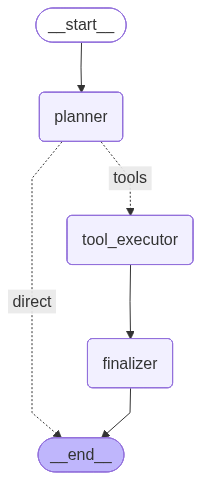

In [12]:
# Visualize the graph
display(
    Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run examples
Let’s see the tool-use agent in action. The examples below test various scenarios. Some require tool use, others only simple answers. This demonstrates how the agent dynamically decides when to invoke external tools versus when to answer directly.

In [13]:
# Example 1: Wikipedia tool use
user_question = "What is the population of Spain in 2025?"  # Example user query
state = AgentState(messages=[HumanMessage(content=user_question)])  # Initial state: conversation starts with user message
result = agent.invoke(state) # Run the agent
print("=== Example 1 ===")  # Print the conversation history
for msg in result["messages"]:
    print(f"{msg.type.upper()}: {msg.content}")

# Example 2: Calculator tool use
user_question_2 = "What is (125 * 4) + 99?"
state = AgentState(messages=[HumanMessage(content=user_question_2)])
result = agent.invoke(state)
print("\n=== Example 2 ===")
for msg in result["messages"]:
    print(f"{msg.type.upper()}: {msg.content}")

# Example 3: Combined Wikipedia and calculator
user_question_3 = "What is the population of Spain in 2025? And what is (125 * 4) + 99?"
state = AgentState(messages=[HumanMessage(content=user_question_3)])
result = agent.invoke(state)
print("\n=== Example 3 ===")
for msg in result["messages"]:
    print(f"{msg.type.upper()}: {msg.content}")

# Example 4: Direct answer, no tool needed
user_question_4 = "How are you?"
state = AgentState(messages=[HumanMessage(content=user_question_4)])
result = agent.invoke(state)
print("\n=== Example 4 ===")
for msg in result["messages"]:
    print(f"{msg.type.upper()}: {msg.content}")

=== Example 1 ===
HUMAN: What is the population of Spain in 2025?
AI: 
TOOL: "As of 1 July 2025, Spain had a total population of 49,315,949. The modern Kingdom of Spain arose from the accretion of several independent Iberian realms, including the Kingdoms of Le\u00f3n, Castile, Navarre, the Crown of Aragon and Granada,  all of which, together with the modern state of Portugal, were successor states to the late antique Christian Visigothic Kingdom after the Reconquista.\nSpain's population surpassed 49 million inhabitants for the first time in history in 2025, with a total population of 49,315,949 people living in Spain. Its population density, at 97 inhabitants per square kilometre (250/sq mi), is much lower than other Western European countries, yet, with the exception of microstates, it has the highest real density population in Europe, based on density of inhabited areas. With the notable exception of Madrid, Spain's capital city, the most densely populated areas lie around the coas

These examples show how the agent dynamically reacts based on the question type - and make full use of the reasoning + tool use pattern.